# WUM - projekt 2 - milestone 3
## Modelowanie końcowe
#### Paulina Jaszczuk - Jakub Fołtyn

## Import pakietów

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.express as px
import warnings
import matplotlib
from sklearn.metrics import silhouette_score,calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from scipy.cluster.vq import whiten
import copy
warnings.filterwarnings('ignore')

In [ ]:
!pip install hdbscan

## Wczytywanie danych

In [3]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')
data.head()
data.shape

(12330, 18)

Dane dotyczą aktywności użytkowników na podstronach strony typu e-commerce. Każdy wiersz to osobna sesja osobnego użytkownika. Obserwacje zawierają dane dotyczące typu odwiedzonych podstron, czasu spędzonego na nich, pewnych współczynników charakteryzujących podstrony, a także informacje na temat samego użytkownika. Targetem jest zmienna Revenue, która mówi nam o tym, czy podczas sesji została sfinalizowana transakcja (głównie czy klient coś kupił). Nasz projekt dotyczy klasteryzacji, więc dalej będziemy posługiwać się naszą ramką danych bez kolumny targetu, ale na końcu porównamy wyniki.

## Kodowanie danych kategorycznych

In [4]:
osi_df = copy.deepcopy(data)
months = {"Feb":2, "Mar":3, "May":5, "June":6, "Jul":7, "Aug":8, "Sep":9, "Oct":10, "Nov":11, "Dec":12}
weekend = {True:1, False:0}

osi_df['Weekend'] = osi_df['Weekend'].map(weekend)
osi_df['Month'] = osi_df['Month'].map(months)

#cykliczne kodowanie miesięcy
osi_df['Month_sin'] = np.sin(2 * np.pi * osi_df['Month']/12.0)
osi_df['Month_cos'] = np.cos(2 * np.pi * osi_df['Month']/12.0)

data_encoded = pd.get_dummies(data = osi_df, columns = ['VisitorType'])

X = data_encoded.drop(['Revenue', 'Month'], axis = 1)
y = data_encoded['Revenue']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12330 non-null  int64  
 1   Administrative_Duration        12330 non-null  float64
 2   Informational                  12330 non-null  int64  
 3   Informational_Duration         12330 non-null  float64
 4   ProductRelated                 12330 non-null  int64  
 5   ProductRelated_Duration        12330 non-null  float64
 6   BounceRates                    12330 non-null  float64
 7   ExitRates                      12330 non-null  float64
 8   PageValues                     12330 non-null  float64
 9   SpecialDay                     12330 non-null  float64
 10  OperatingSystems               12330 non-null  int64  
 11  Browser                        12330 non-null  int64  
 12  Region                         12330 non-null 

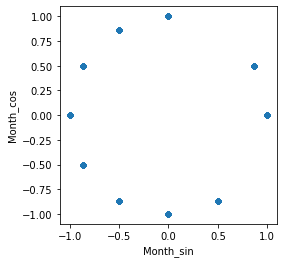

In [ ]:
# wykres zakodowanych miesięcy
ax = X.plot.scatter('Month_sin', 'Month_cos').set_aspect('equal')

## Transformacja logarytmiczna i standaryzacja

Na poprzednim etapie, podczas eksperymentowania z różnymi postaciami danych, okazało się, że clustering najlepiej przebiega na ramce ze zlogarytmowanymi pierwszymi 6 kolumnami. Zawierają one informacje dotyczące liczby odwiedzonych stron oraz czasu spędzonego na nich, przez co wartości te bardzo odbiegają od innych w naszej ramce danych. Dlatego też dalej będziemy pracować na danych zlogarytmowanych.

In [5]:
X_log = copy.deepcopy(X) 
X_log.iloc[:,0:6] = X_log.iloc[:,0:6].apply(lambda x: np.log1p(x), axis=1)

Z naszych doświadczeń z poprzedniego etapu wynika, że PCA na zbiorze niewystandaryzowanym może bardzo zakłamywać rzeczywistość, dlatego też postanowiliśmy przygotować wystandaryzowaną wersję danych.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_log_standard = pd.DataFrame(scaler.fit_transform(X_log))

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

minmaxscaler = MinMaxScaler()
normalizer = Normalizer()

In [8]:
X_log_minmax = pd.DataFrame(minmaxscaler.fit_transform(X_log))
X_log_normal = pd.DataFrame(normalizer.fit_transform(X_log))

## PCA

In [ ]:
def PCA_test(X):
  pca = PCA(n_components=17).fit(X)
  plt.figure(figsize=(9,6))
  plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance')
  plt.axhline(y=0.95, color='r', linestyle='-')
  plt.text(0.5, 0.97, '95% cut-off threshold', color = 'red', fontsize=16)
  treshold = np.abs(np.cumsum(pca.explained_variance_ratio_)-0.95).argmin() + 1
  print("Number of components that explain 95% variance: {}".format(treshold));

Number of components that explain 95% variance: 14


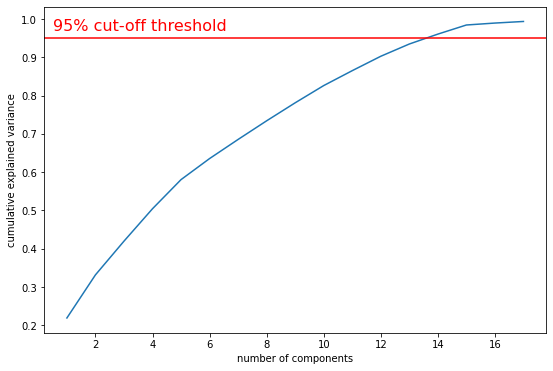

In [ ]:
# dane zlogarytmowane po standaryzacji StandardScalerem
PCA_test(X_log_standard)

Number of components that explain 95% variance: 11


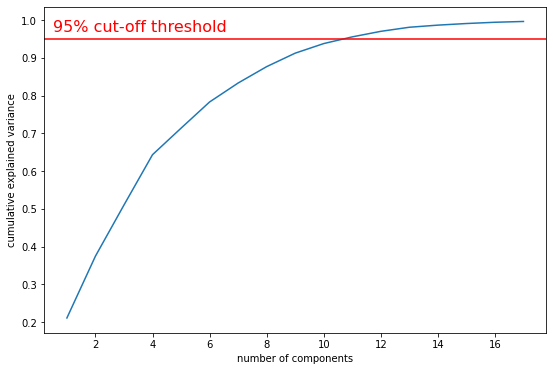

In [ ]:
# dane zlogarytmowane po standaryzacji MinMaxScalerem
PCA_test(X_log_minmax)

Number of components that explain 95% variance: 8


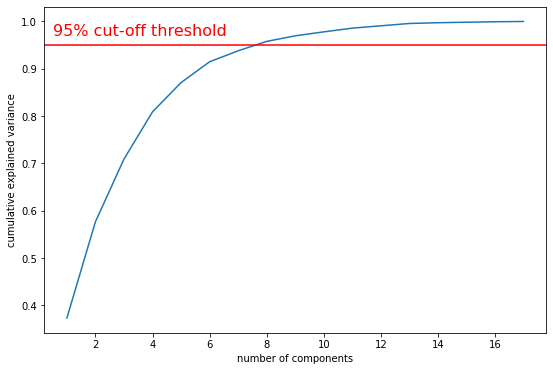

In [ ]:
# dane zlogarytmowane po normalizacji wierszowej Normalizerem
PCA_test(X_log_normal)

Jak widać przy normalizacji, 8 komponentów wyjaśnia nam już 95% wariancji.

In [9]:
X_log_normal_pca8 = PCA(n_components=8).fit_transform(X_log_normal)
X_log_minmax_pca11 = PCA(n_components=11).fit_transform(X_log_minmax)
X_log_std_pca14 = PCA(n_components=14).fit_transform(X_log_standard)

## Klasteryzacja

W procesie klasteryzacji będziemy eksperymentować - porównamy ze sobą wyniki dla 8 różnych zbiorów danych, a jakość clusteringu zmierzymy metrykami *Silhuette score* oraz *Calinski Harabasz score*. Oprócz zbioru oryginalnego użyjemy `X_log`, który najlepiej się "klastrował" podczas wstępnego modelowania. 3 kolejne zbiory to różne warianty zestandaryzowanej ramki `X_log`, kolejne to przetransformowane przez PCA ramki tak, by liczba komponentów dla każdej ramki wyjaśniała ok. 95% wariancji.

### Funkcje pomocnicze

In [10]:
from scipy.cluster.hierarchy import linkage, fcluster

# funkcja klasteryzuje dane metodą hierarchiczną
def hierarchy_clustering(df, method='ward', metric='euclidean'):
    if 'cluster_labels' in df:
      df.drop('cluster_labels', axis=1, inplace=True)
    distance_matrix = linkage(df, method = method, metric = metric)
    cluster_labels = fcluster(distance_matrix, 2, criterion='maxclust')
    return df, cluster_labels

In [11]:
from scipy.cluster.vq import kmeans, vq

# funkcja klasteryzuje dane metodą K-means
def kmeans_clustering(df) :
    if 'cluster_labels' in df:
      df.drop('cluster_labels', axis=1, inplace=True)
    cluster_centers, distortion = kmeans(df, 2)
    cluster_labels, distortion_list = vq(df, cluster_centers)
    return df, cluster_labels

In [12]:
from sklearn import cluster, datasets, mixture

# funkcja klasteryzuje dane metodą DBSCAN
def DBSCAN_clustering(X, eps=0.3):
    dbs = cluster.DBSCAN(eps=eps)
    dbs.fit(X)
    if hasattr(dbs, 'labels_'):
        y_pred = dbs.labels_.astype(np.int)
    else:
        y_pred = dbs.predict(X)
    return X, y_pred

In [ ]:
import hdbscan

# funkcja klasteryzuje dane metodą HDBSCAN
def HDBSCAN_clustering(X, min_cluster_size=5):
    hdbs = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    hdbs.fit(X)
    y_pred = hdbs.fit_predict(X)
    return X, y_pred

In [17]:
# funkcja klasteryzuje dane metodą GMM
def GMM_clustering(X, covariance_type='full'):
    gmm = mixture.GaussianMixture(n_components=2, covariance_type=covariance_type)
    gmm.fit(X)
    if hasattr(gmm, 'labels_'):
        y_pred = gmm.labels_.astype(np.int)
    else:
        y_pred = gmm.predict(X)
    return X, y_pred

In [18]:
# funckja oblicza wartości Silhuette Score i Calinski Harabasz Score dla 8 ramek danych:
def comparison(method, df1 = X, df2 = X_log, df3 = X_log_standard, df4 = X_log_minmax, df5 = X_log_normal, 
               df6 = X_log_normal_pca8, df7 = X_log_minmax_pca11, df8 = X_log_std_pca14):
  silhuette = []
  calinski_harabasz = []
  d = {}
  arguments = locals()
  iters = list(locals().keys())[1:9]
  for i in iters:
    x = method(arguments[i])
    silhuette.append(silhouette_score(*x))
    calinski_harabasz.append(calinski_harabasz_score(*x))
  d = {'silhuette': silhuette,'calinski_harabasz':calinski_harabasz}
  index = ['org', 'log', 'log_std', 'log_minmax', 'log_normal', 'log_normal_pca8', 'log_minmax_pca11', 'log_std_pca14']
  print(pd.DataFrame(d, columns=['silhuette', 'calinski_harabasz'], index = index))

### Klastrowanie hierarchiczne

In [ ]:
comparison(hierarchy_clustering)

                  silhuette  calinski_harabasz
org                0.834663       11187.208055
log                0.759619       14535.028942
log_std            0.301841        1600.661676
log_minmax         0.296635        2783.141908
log_normal         0.409325        5700.764995
log_normal_pca8    0.390145        6146.579736
log_minmax_pca11   0.307439        2943.188531
log_std_pca14      0.310649        1652.166015


W klastrowaniu hierarchicznym najlepiej radziły sobie zbiór surowy oraz zlogarytmowany. Ten pierwszy osiągnął lepszy wynik w *Silhuette Score*, zaś drugi w *Calinski Harabasz Score*. Pozostałe zbiory radzą sobie znacznie gorzej.

### Klastrowanie kmeans

In [ ]:
comparison(kmeans_clustering)

                  silhuette  calinski_harabasz
org                0.718966       12014.241283
log                0.784008       15717.850131
log_std            0.138576        1942.923615
log_minmax         0.304165        2850.523800
log_normal         0.403050        6218.947277
log_normal_pca8    0.419109        6636.408046
log_minmax_pca11   0.314170        3015.950189
log_std_pca14      0.145664        2034.453599


Ponownie najlepsze wyniki uzyskano na zbiorach surowym i zlogartmowanym. Tym razem zbiór zlogarytmowany wygrał w obu miarach. Pozostałe zbiory znowu zostały daleko w tyle.

### DBSCAN

In [ ]:
# eps=0.3
comparison(DBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.359689           2.830807
log               -0.458130           2.343176
log_std           -0.301190          21.112079
log_minmax        -0.259471          89.953222
log_normal         0.173173          41.350818
log_normal_pca8    0.189223          10.136623
log_minmax_pca11  -0.151428         167.799923
log_std_pca14     -0.390233          10.941526


In [ ]:
# eps=0.2
comparison(DBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.360560           2.912319
log               -0.413713           2.490451
log_std            0.196189          29.638740
log_minmax        -0.411708          29.474116
log_normal        -0.247189          26.671063
log_normal_pca8   -0.148652          34.057205
log_minmax_pca11  -0.274757          67.636045
log_std_pca14     -0.370275          14.951245


In [ ]:
# eps=0.35
comparison(DBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.359689           2.830807
log               -0.461728           2.230604
log_std           -0.319184          16.610861
log_minmax        -0.195203         143.367613
log_normal         0.191987          16.925580
log_normal_pca8    0.245997           9.391305
log_minmax_pca11  -0.062213         232.939278
log_std_pca14     -0.423795          10.663181


DBSCAN uzyskał bardzo słabe wynika na wszytskich zbiorach bez względu na wartość parametru *eps*.

### HDBSCAN

In [ ]:
# min_cluster_size = 5
comparison(HDBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.583551          27.103903
log               -0.532322          34.829208
log_std           -0.271612          63.546249
log_minmax        -0.139957         157.974129
log_normal        -0.381067          55.502787
log_normal_pca8   -0.310026          45.888981
log_minmax_pca11  -0.215696          63.712303
log_std_pca14     -0.257373          47.695656


In [ ]:
# min_cluster_size = 20
comparison(HDBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.640194          39.606864
log                0.432437        3267.039793
log_std            0.580922         339.866014
log_minmax         0.206832        1104.272094
log_normal         0.043220         930.058314
log_normal_pca8   -0.118889         480.165841
log_minmax_pca11   0.102193         739.665281
log_std_pca14      0.589478         354.918082


In [ ]:
# min_cluster_size = 70
comparison(HDBSCAN_clustering)

                  silhuette  calinski_harabasz
org               -0.550242          72.744367
log               -0.015524         555.245327
log_std            0.176780         860.164187
log_minmax         0.190594        1223.695164
log_normal         0.127535        2993.231855
log_normal_pca8    0.166146        3214.018059
log_minmax_pca11   0.198813        1259.606711
log_std_pca14      0.182033         879.138995


HDBSCAN również radził sobie znacznie gorzej niż m.in. Kmeans. Najlepszy wynik osiągnął dla ramki zlogarytmowanej przy parametrze *min_cluster_size* równym 20.

### GMM

In [ ]:
comparison(GMM_clustering)

                  silhuette  calinski_harabasz
org                0.245719        2681.672502
log               -0.099050         311.734271
log_std            0.129037        1729.161446
log_minmax         0.205116        2068.004450
log_normal         0.213799        2962.656163
log_normal_pca8    0.235992        3292.983768
log_minmax_pca11   0.162638        1631.284643
log_std_pca14      0.135004        1799.268020


GMM najlepszy wynik uzyskał dla ramki znormalizowanej i sprowadzonej przy użyciu PCA do 8 wymiarów, ale wynik obie miary mocno odbiegają od wyników np. klastrowania hierarchicznego.

Po przeanalizowaniu wyników odrzuciliśmy DBSCAN, HDBSCAN oraz GMM, które to radziły sobie na naszych danych kilkakrotnie gorzej. Postanowiliśmy rozważać dalej klastrowanie hierarchiczne oraz K-Means. Dodatkowo ograniczyliśmy się do zlogarytmowanych danych, na których to obie metody klasteryzacji wypadły bardzo dobrze. Potwierdza to nasze wnioski z poprzedniego etapu. 

## Wizualizacje

Podjęliśmy próbę wizualizacji wybranych danych i algorytmów klastrowania. Dane przedstawiliśmy graficznie w 2d - po zmniejszeniu wymiarowości przy pomocy PCA, oraz w 3d (T-SNE).

### 2d

In [ ]:
# funckja wizualizuje zklastrowane dane po zmniejszeniu do 2 wymiarów (metodą PCA)
def visualisation(df, method, title):
  data, labels = method(df)
  sns.scatterplot(x=0, y=1, hue=labels, data = pd.DataFrame(data))
  plt.title(title)
  plt.show()

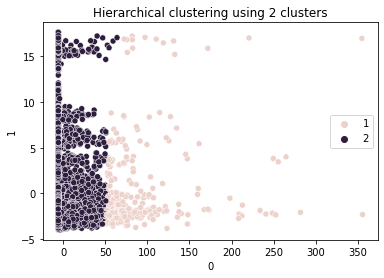

In [ ]:
# klastrowanie hierarchiczne
visualisation(PCA(n_components=2).fit_transform(X_log), hierarchy_clustering, 'Hierarchical clustering using 2 clusters')

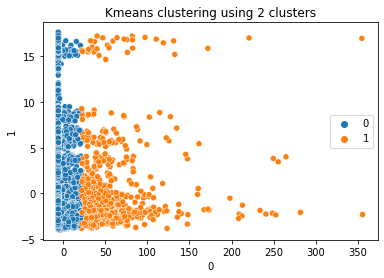

In [ ]:
# klastrowanie kmeans
visualisation(PCA(n_components=2).fit_transform(X_log), kmeans_clustering, 'Kmeans clustering using 2 clusters')

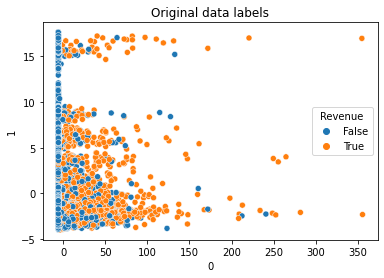

In [ ]:
# oryginalne etykiety danych
sns.scatterplot(x=0, y=1, hue=y, data = pd.DataFrame(PCA(n_components=2).fit_transform(X_log)))
plt.title("Original data labels")
plt.show()

### T-SNE 3d 

In [19]:
y_tsne = copy.deepcopy(y)
org_labels_tsne = {False:1, True:0}
y_tsne = y_tsne.map(org_labels_tsne)

perplexities = [50,100,150,200]

In [20]:
def test_tsne(X, perplexity, color):
  tsne = TSNE(n_components=3,perplexity=perplexity)
  transformed = tsne.fit_transform(X)
  fig = px.scatter_3d(
    transformed, x=0, y=1, z=2, color=color,
    labels={'0': 'X', '1': 'Y', '2': 'Z'},
    title = "3d T-SNE plot for perplexity={}".format(perplexity) 
    
  )
  fig.show()

In [21]:
def draw_tsne(X, cluster_labels):
  for i in range(4):
    test_tsne(X, perplexities[i], cluster_labels)

In [ ]:
# poniższe trzy komórki pozostawiamy niewywołane, bo rozmiar pliku jest wówczas ogromny. Wizualizacje dostępne są w HTML.
df, cluster_labels = hierarchy_clustering(X_log)
draw_tsne(df, cluster_labels)

In [ ]:
df, cluster_labels = kmeans_clustering(X_log)
draw_tsne(df, cluster_labels)

In [ ]:
draw_tsne(X_log, y_tsne)

Niestety, nie jesteśmy w stanie zredukować wymiarowości naszych danych do liczby "przyjaznej człowiekowi". W związku z tym, należy liczyć się z pewnymi błędami powstałymi przy próbach wizualizacji naszych klasteryzacji w niższych (2 i 3) wymiarach, błędy te są naturalnie związane z procesem redukcji wymiarów. 

## Porównanie z oryginalnymi etykietami

Miary takie jak *Silhuette Score* czy *Calinski Harabasz Score* oraz wizualizacje pomogły nam wybrać model i formę danych, natomiast nie odpowiadają nam one w pełni na pytanie o jakość klasteryzacji. W tym celu porównajmy finalne etykiety nadane danym w procesie clusteringu z tymi oryginalnymi.

In [ ]:
df, labels_hier = hierarchy_clustering(X_log)

In [ ]:
y_hier = copy.deepcopy(y)
org_labels_hier = {False:1, True:2}
y_hier = y_hier.map(org_labels_hier)

In [ ]:
# Klasteryzacja hierarchiczna
print("Procent prawidłowo sklasyfikowanych danych: {}%".format(round(sum(labels_hier == y_hier)/len(labels_hier)*100)))

Procent prawidłowo sklasyfikowanych danych: 89%


In [ ]:
df, labels_kmeans = kmeans_clustering(X_log)

In [ ]:
y_kmeans = copy.deepcopy(y)
org_labels_kmeans = {False:1, True:0}
y_kmeans = y_kmeans.map(org_labels_kmeans)

In [ ]:
# Klasteryzacja K-means
print("Procent prawidłowo sklasyfikowanych danych: {}%".format(round(sum(labels_kmeans == y_kmeans)/len(labels_kmeans)*100)))

Procent prawidłowo sklasyfikowanych danych: 88%


## Podsumowanie


* Udało nam się przypisać do odpowiedniej grupy prawie 89% obserwacji.
* W procesie klasteryzacji nie zastosowaliśmy metody PCA do zmniejszenia wymiarowości danych - za każdym razem znacząco pogarszała ona wyniki.
* Najlepsze wyniki uzyskaliśmy na danych ze zlogarytmowanymi pierwszymi 6 kolumnami. 
* Algorytmy  "najprostsze" okazały się najskuteczniejsze.